In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    ################################################ s', Q = env(s, a)
    ################################################ ~s', ~Q = env(s, ~a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                   labels=next_states_labels)) # real loss
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs_logits, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                  action_size=action_size, state_size=state_size, reuse=True)
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
#     eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
#                                                                     labels=tf.zeros_like(rates))) # min
#     aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=aQs2_logits, # GAN
#                                                                      labels=tf.ones_like(rates))) # max
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a') # max
    ###################################################### ~Q(s,~a)= r # min
    ###################################################### ~Q(s,~a)= r + Q'(s',a') # max
    targetQs = rewards + (gamma * aQs2_logits)
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # minimize Q
    aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # maximize Q
    eloss += tf.reduce_mean(targetQs) # minimize Q
    aloss2 += -tf.reduce_mean(targetQs) # maxizmie Q
    eloss += tf.reduce_mean(eQs_logits) # minimize Q
    aloss2 += -tf.reduce_mean(eQs_logits) # maxizmie Q
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        num_step = 0
        rate = -1

        # Training steps/batches
        while True:
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                states = states[rates >= np.max(rates)]
                actions = actions[rates >= np.max(rates)]
                next_states = next_states[rates >= np.max(rates)]
                rewards = rewards[rates >= np.max(rates)]
                dones = dones[rates >= np.max(rates)]
                rates = rates[rates >= np.max(rates)]
                if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
                    break
            aloss, _ = sess.run([model.a_loss, model.a_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            eloss, _ = sess.run([model.e_loss, model.e_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.next_states: next_states,
                                               model.rewards: rewards,
                                               model.dones: dones,
                                               model.rates: rates})
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            # print(len(dones), np.count_nonzero(dones), np.max(rates))
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        # Rating the latest played episode
        rate = total_reward/500 # update rate at the end/ when episode is done
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                memory.buffer[-1-idx][-1] = rate # rate the trajectory/data

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:13.0000 R:13.0000 rate:0.0260 aloss:0.6870 eloss:4.5059 aloss2:1.6095 exploreP:0.9987
Episode:1 meanR:24.0000 R:35.0000 rate:0.0700 aloss:0.6901 eloss:4.5047 aloss2:1.6270 exploreP:0.9953
Episode:2 meanR:21.6667 R:17.0000 rate:0.0340 aloss:0.6888 eloss:4.4757 aloss2:1.5675 exploreP:0.9936
Episode:3 meanR:22.7500 R:26.0000 rate:0.0520 aloss:0.6880 eloss:4.5016 aloss2:1.6099 exploreP:0.9910
Episode:4 meanR:23.2000 R:25.0000 rate:0.0500 aloss:0.6833 eloss:4.4821 aloss2:1.5845 exploreP:0.9886
Episode:5 meanR:24.0000 R:28.0000 rate:0.0560 aloss:0.6997 eloss:4.4830 aloss2:1.5620 exploreP:0.9858
Episode:6 meanR:22.7143 R:15.0000 rate:0.0300 aloss:0.6944 eloss:4.4705 aloss2:1.4773 exploreP:0.9844
Episode:7 meanR:23.5000 R:29.0000 rate:0.0580 aloss:0.6986 eloss:4.4773 aloss2:1.5510 exploreP:0.9816
Episode:8 meanR:22.0000 R:10.0000 rate:0.0200 aloss:0.6839 eloss:4.4572 aloss2:1.4846 exploreP:0.9806
Episode:9 meanR:21.1000 R:13.0000 rate:0.0260 aloss:0.6894 eloss:4.4534 aloss2:1.5

Episode:80 meanR:27.8025 R:24.0000 rate:0.0480 aloss:0.6672 eloss:4.3280 aloss2:1.5332 exploreP:0.8004
Episode:81 meanR:27.9146 R:37.0000 rate:0.0740 aloss:0.6807 eloss:4.3319 aloss2:1.5272 exploreP:0.7975
Episode:82 meanR:27.7831 R:17.0000 rate:0.0340 aloss:0.6665 eloss:4.3194 aloss2:1.5438 exploreP:0.7961
Episode:83 meanR:27.9048 R:38.0000 rate:0.0760 aloss:0.6846 eloss:4.3241 aloss2:1.5640 exploreP:0.7931
Episode:84 meanR:28.5176 R:80.0000 rate:0.1600 aloss:0.6788 eloss:4.3311 aloss2:1.6431 exploreP:0.7869
Episode:85 meanR:28.5581 R:32.0000 rate:0.0640 aloss:0.6785 eloss:4.3176 aloss2:1.5930 exploreP:0.7844
Episode:86 meanR:28.7241 R:43.0000 rate:0.0860 aloss:0.6879 eloss:4.3211 aloss2:1.6008 exploreP:0.7811
Episode:87 meanR:29.1250 R:64.0000 rate:0.1280 aloss:0.6684 eloss:4.3124 aloss2:1.5760 exploreP:0.7762
Episode:88 meanR:29.0674 R:24.0000 rate:0.0480 aloss:0.6654 eloss:4.3112 aloss2:1.5487 exploreP:0.7743
Episode:89 meanR:29.4111 R:60.0000 rate:0.1200 aloss:0.6770 eloss:4.3268 

Episode:159 meanR:50.2600 R:75.0000 rate:0.1500 aloss:0.7517 eloss:4.2826 aloss2:2.0992 exploreP:0.5220
Episode:160 meanR:51.5600 R:165.0000 rate:0.3300 aloss:0.7622 eloss:4.2799 aloss2:2.0971 exploreP:0.5136
Episode:161 meanR:52.3600 R:99.0000 rate:0.1980 aloss:0.7682 eloss:4.2776 aloss2:2.1118 exploreP:0.5087
Episode:162 meanR:53.4400 R:128.0000 rate:0.2560 aloss:0.7569 eloss:4.2844 aloss2:2.1161 exploreP:0.5023
Episode:163 meanR:53.8500 R:58.0000 rate:0.1160 aloss:0.7847 eloss:4.2840 aloss2:2.1228 exploreP:0.4995
Episode:164 meanR:55.2300 R:167.0000 rate:0.3340 aloss:0.7632 eloss:4.2771 aloss2:2.1404 exploreP:0.4914
Episode:165 meanR:56.8200 R:178.0000 rate:0.3560 aloss:0.7416 eloss:4.2743 aloss2:2.1553 exploreP:0.4829
Episode:166 meanR:58.0800 R:187.0000 rate:0.3740 aloss:0.7528 eloss:4.2737 aloss2:2.1365 exploreP:0.4741
Episode:167 meanR:61.8300 R:416.0000 rate:0.8320 aloss:0.7653 eloss:4.2721 aloss2:2.1336 exploreP:0.4552
Episode:168 meanR:64.4300 R:272.0000 rate:0.5440 aloss:0.7

Episode:238 meanR:90.4000 R:29.0000 rate:0.0580 aloss:0.7047 eloss:4.2414 aloss2:2.0929 exploreP:0.2552
Episode:239 meanR:90.0500 R:16.0000 rate:0.0320 aloss:0.6993 eloss:4.2459 aloss2:2.0813 exploreP:0.2548
Episode:240 meanR:89.1100 R:20.0000 rate:0.0400 aloss:0.7058 eloss:4.2494 aloss2:2.0927 exploreP:0.2543
Episode:241 meanR:88.7500 R:11.0000 rate:0.0220 aloss:0.7099 eloss:4.2380 aloss2:2.1235 exploreP:0.2540
Episode:242 meanR:86.5700 R:14.0000 rate:0.0280 aloss:0.7126 eloss:4.2443 aloss2:2.1058 exploreP:0.2537
Episode:243 meanR:86.0300 R:11.0000 rate:0.0220 aloss:0.7060 eloss:4.2436 aloss2:2.1298 exploreP:0.2534
Episode:244 meanR:86.0100 R:11.0000 rate:0.0220 aloss:0.7066 eloss:4.2442 aloss2:2.0832 exploreP:0.2532
Episode:245 meanR:85.8300 R:9.0000 rate:0.0180 aloss:0.7037 eloss:4.2370 aloss2:2.1184 exploreP:0.2529
Episode:246 meanR:85.4100 R:10.0000 rate:0.0200 aloss:0.7088 eloss:4.2351 aloss2:2.1459 exploreP:0.2527
Episode:247 meanR:83.8800 R:10.0000 rate:0.0200 aloss:0.7148 elos

Episode:317 meanR:16.8400 R:14.0000 rate:0.0280 aloss:0.7173 eloss:4.2364 aloss2:2.1256 exploreP:0.2353
Episode:318 meanR:16.6600 R:10.0000 rate:0.0200 aloss:0.7266 eloss:4.2430 aloss2:2.1250 exploreP:0.2351
Episode:319 meanR:16.5300 R:11.0000 rate:0.0220 aloss:0.7107 eloss:4.2454 aloss2:2.1035 exploreP:0.2348
Episode:320 meanR:16.3400 R:10.0000 rate:0.0200 aloss:0.7057 eloss:4.2351 aloss2:2.1207 exploreP:0.2346
Episode:321 meanR:16.2800 R:10.0000 rate:0.0200 aloss:0.7186 eloss:4.2334 aloss2:2.1134 exploreP:0.2344
Episode:322 meanR:16.2300 R:9.0000 rate:0.0180 aloss:0.7093 eloss:4.2243 aloss2:2.1087 exploreP:0.2342
Episode:323 meanR:16.1000 R:12.0000 rate:0.0240 aloss:0.7158 eloss:4.2414 aloss2:2.1041 exploreP:0.2339
Episode:324 meanR:15.9400 R:9.0000 rate:0.0180 aloss:0.7096 eloss:4.2294 aloss2:2.1215 exploreP:0.2337
Episode:325 meanR:15.7100 R:10.0000 rate:0.0200 aloss:0.7131 eloss:4.2263 aloss2:2.1169 exploreP:0.2335
Episode:326 meanR:15.5900 R:9.0000 rate:0.0180 aloss:0.7236 eloss:

Episode:397 meanR:10.3600 R:10.0000 rate:0.0200 aloss:0.7101 eloss:4.2153 aloss2:2.1007 exploreP:0.2173
Episode:398 meanR:10.3500 R:9.0000 rate:0.0180 aloss:0.7103 eloss:4.2178 aloss2:2.0942 exploreP:0.2172
Episode:399 meanR:10.3500 R:12.0000 rate:0.0240 aloss:0.7116 eloss:4.2232 aloss2:2.0950 exploreP:0.2169
Episode:400 meanR:10.4000 R:13.0000 rate:0.0260 aloss:0.7280 eloss:4.2268 aloss2:2.0881 exploreP:0.2166
Episode:401 meanR:10.3900 R:10.0000 rate:0.0200 aloss:0.7116 eloss:4.2199 aloss2:2.0758 exploreP:0.2164
Episode:402 meanR:10.4200 R:11.0000 rate:0.0220 aloss:0.7109 eloss:4.2209 aloss2:2.0892 exploreP:0.2162
Episode:403 meanR:10.4100 R:9.0000 rate:0.0180 aloss:0.7184 eloss:4.2423 aloss2:2.0781 exploreP:0.2160
Episode:404 meanR:10.4200 R:13.0000 rate:0.0260 aloss:0.7066 eloss:4.2157 aloss2:2.0798 exploreP:0.2158
Episode:405 meanR:10.4000 R:10.0000 rate:0.0200 aloss:0.7120 eloss:4.2211 aloss2:2.0876 exploreP:0.2156
Episode:406 meanR:10.3800 R:9.0000 rate:0.0180 aloss:0.7107 eloss:

Episode:476 meanR:11.0900 R:16.0000 rate:0.0320 aloss:0.7115 eloss:4.2150 aloss2:2.0815 exploreP:0.1999
Episode:477 meanR:11.0900 R:9.0000 rate:0.0180 aloss:0.7135 eloss:4.2138 aloss2:2.0806 exploreP:0.1997
Episode:478 meanR:11.0800 R:10.0000 rate:0.0200 aloss:0.6915 eloss:4.2034 aloss2:2.1004 exploreP:0.1995
Episode:479 meanR:11.0700 R:11.0000 rate:0.0220 aloss:0.7208 eloss:4.2368 aloss2:2.0535 exploreP:0.1993
Episode:480 meanR:11.1000 R:11.0000 rate:0.0220 aloss:0.7124 eloss:4.2146 aloss2:2.0952 exploreP:0.1991
Episode:481 meanR:11.1100 R:12.0000 rate:0.0240 aloss:0.7019 eloss:4.2101 aloss2:2.1011 exploreP:0.1989
Episode:482 meanR:11.0900 R:9.0000 rate:0.0180 aloss:0.7150 eloss:4.2160 aloss2:2.0837 exploreP:0.1987
Episode:483 meanR:11.0900 R:10.0000 rate:0.0200 aloss:0.6960 eloss:4.2327 aloss2:2.0893 exploreP:0.1985
Episode:484 meanR:11.2100 R:22.0000 rate:0.0440 aloss:0.6988 eloss:4.2300 aloss2:2.0866 exploreP:0.1981
Episode:485 meanR:11.2200 R:11.0000 rate:0.0220 aloss:0.7149 eloss

Episode:555 meanR:143.1200 R:171.0000 rate:0.3420 aloss:0.6837 eloss:4.2466 aloss2:2.0799 exploreP:0.0565
Episode:556 meanR:145.7500 R:273.0000 rate:0.5460 aloss:0.6782 eloss:4.2469 aloss2:2.0686 exploreP:0.0553
Episode:557 meanR:147.0100 R:137.0000 rate:0.2740 aloss:0.6880 eloss:4.2441 aloss2:2.0711 exploreP:0.0547
Episode:558 meanR:149.1900 R:231.0000 rate:0.4620 aloss:0.6886 eloss:4.2420 aloss2:2.0776 exploreP:0.0536
Episode:559 meanR:150.5200 R:145.0000 rate:0.2900 aloss:0.6938 eloss:4.2528 aloss2:2.0717 exploreP:0.0530
Episode:560 meanR:151.5600 R:114.0000 rate:0.2280 aloss:0.6953 eloss:4.2423 aloss2:2.0559 exploreP:0.0525
Episode:561 meanR:152.7100 R:125.0000 rate:0.2500 aloss:0.6682 eloss:4.2450 aloss2:2.0627 exploreP:0.0520
Episode:562 meanR:153.8000 R:124.0000 rate:0.2480 aloss:0.6843 eloss:4.2396 aloss2:2.0600 exploreP:0.0515
Episode:563 meanR:155.2300 R:155.0000 rate:0.3100 aloss:0.6815 eloss:4.2452 aloss2:2.0593 exploreP:0.0508
Episode:564 meanR:157.5000 R:238.0000 rate:0.4

Episode:633 meanR:204.2400 R:362.0000 rate:0.7240 aloss:0.6503 eloss:4.2686 aloss2:2.0476 exploreP:0.0210
Episode:634 meanR:205.9100 R:500.0000 rate:1.0000 aloss:0.6412 eloss:4.2736 aloss2:2.0316 exploreP:0.0205
Episode:635 meanR:208.7900 R:500.0000 rate:1.0000 aloss:0.6465 eloss:4.2719 aloss2:2.0165 exploreP:0.0200
Episode:636 meanR:209.9100 R:300.0000 rate:0.6000 aloss:0.6398 eloss:4.2711 aloss2:2.0227 exploreP:0.0197
Episode:637 meanR:209.1800 R:191.0000 rate:0.3820 aloss:0.6302 eloss:4.2744 aloss2:2.0258 exploreP:0.0195
Episode:638 meanR:211.9300 R:500.0000 rate:1.0000 aloss:0.6427 eloss:4.2741 aloss2:2.0160 exploreP:0.0190
Episode:639 meanR:211.8700 R:283.0000 rate:0.5660 aloss:0.6440 eloss:4.2723 aloss2:2.0283 exploreP:0.0188
Episode:640 meanR:212.3600 R:435.0000 rate:0.8700 aloss:0.6209 eloss:4.2792 aloss2:2.0098 exploreP:0.0184
Episode:641 meanR:212.3900 R:184.0000 rate:0.3680 aloss:0.6574 eloss:4.2739 aloss2:2.0160 exploreP:0.0183
Episode:642 meanR:214.8700 R:447.0000 rate:0.8

Episode:711 meanR:369.2200 R:216.0000 rate:0.4320 aloss:0.5577 eloss:4.3014 aloss2:1.8374 exploreP:0.0105
Episode:712 meanR:373.4300 R:500.0000 rate:1.0000 aloss:0.5523 eloss:4.3031 aloss2:1.8426 exploreP:0.0105
Episode:713 meanR:376.8700 R:500.0000 rate:1.0000 aloss:0.5498 eloss:4.2993 aloss2:1.8342 exploreP:0.0105
Episode:714 meanR:380.5000 R:500.0000 rate:1.0000 aloss:0.5512 eloss:4.3014 aloss2:1.8457 exploreP:0.0104
Episode:715 meanR:381.5400 R:175.0000 rate:0.3500 aloss:0.5458 eloss:4.3033 aloss2:1.8418 exploreP:0.0104
Episode:716 meanR:384.1500 R:500.0000 rate:1.0000 aloss:0.5535 eloss:4.3007 aloss2:1.8405 exploreP:0.0104
Episode:717 meanR:383.2600 R:138.0000 rate:0.2760 aloss:0.5602 eloss:4.2990 aloss2:1.8297 exploreP:0.0104
Episode:718 meanR:386.7400 R:500.0000 rate:1.0000 aloss:0.5441 eloss:4.3014 aloss2:1.8353 exploreP:0.0104
Episode:719 meanR:387.2200 R:500.0000 rate:1.0000 aloss:0.5350 eloss:4.3025 aloss2:1.8224 exploreP:0.0104
Episode:720 meanR:387.7700 R:207.0000 rate:0.4

Episode:789 meanR:417.1300 R:500.0000 rate:1.0000 aloss:0.4327 eloss:4.1969 aloss2:1.7433 exploreP:0.0100
Episode:790 meanR:414.3100 R:218.0000 rate:0.4360 aloss:0.4432 eloss:4.1850 aloss2:1.7447 exploreP:0.0100
Episode:791 meanR:410.9100 R:160.0000 rate:0.3200 aloss:0.4338 eloss:4.1720 aloss2:1.7303 exploreP:0.0100
Episode:792 meanR:410.9100 R:500.0000 rate:1.0000 aloss:0.4372 eloss:4.1860 aloss2:1.7718 exploreP:0.0100
Episode:793 meanR:407.9800 R:207.0000 rate:0.4140 aloss:0.4303 eloss:4.1593 aloss2:1.7590 exploreP:0.0100
Episode:794 meanR:411.3700 R:500.0000 rate:1.0000 aloss:0.4385 eloss:4.1786 aloss2:1.7682 exploreP:0.0100
Episode:795 meanR:407.8900 R:152.0000 rate:0.3040 aloss:0.4328 eloss:4.1526 aloss2:1.8092 exploreP:0.0100
Episode:796 meanR:404.7600 R:187.0000 rate:0.3740 aloss:0.4350 eloss:4.1628 aloss2:1.8155 exploreP:0.0100
Episode:797 meanR:405.0700 R:500.0000 rate:1.0000 aloss:0.4307 eloss:4.1447 aloss2:1.8088 exploreP:0.0100
Episode:798 meanR:401.7000 R:163.0000 rate:0.3

Episode:867 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3652 eloss:4.0747 aloss2:1.4557 exploreP:0.0100
Episode:868 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3623 eloss:4.0203 aloss2:1.4610 exploreP:0.0100
Episode:869 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3615 eloss:3.9783 aloss2:1.5074 exploreP:0.0100
Episode:870 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3546 eloss:3.9269 aloss2:1.5046 exploreP:0.0100
Episode:871 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3532 eloss:3.9022 aloss2:1.4977 exploreP:0.0100
Episode:872 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3543 eloss:3.8750 aloss2:1.4823 exploreP:0.0100
Episode:873 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3587 eloss:3.8958 aloss2:1.4500 exploreP:0.0100
Episode:874 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3607 eloss:3.8995 aloss2:1.4257 exploreP:0.0100
Episode:875 meanR:455.0500 R:500.0000 rate:1.0000 aloss:0.3693 eloss:3.8972 aloss2:1.4345 exploreP:0.0100
Episode:876 meanR:455.0500 R:500.0000 rate:1.0

Episode:945 meanR:488.3200 R:195.0000 rate:0.3900 aloss:0.4254 eloss:3.6173 aloss2:4.3938 exploreP:0.0100
Episode:946 meanR:490.0200 R:500.0000 rate:1.0000 aloss:0.4248 eloss:3.6057 aloss2:4.4993 exploreP:0.0100
Episode:947 meanR:489.1300 R:234.0000 rate:0.4680 aloss:0.4242 eloss:3.5981 aloss2:4.5991 exploreP:0.0100
Episode:948 meanR:489.1300 R:500.0000 rate:1.0000 aloss:0.4227 eloss:3.5799 aloss2:4.7099 exploreP:0.0100
Episode:949 meanR:486.1800 R:205.0000 rate:0.4100 aloss:0.4214 eloss:3.5755 aloss2:4.8098 exploreP:0.0100
Episode:950 meanR:486.1800 R:500.0000 rate:1.0000 aloss:0.4201 eloss:3.5465 aloss2:4.8540 exploreP:0.0100
Episode:951 meanR:486.1800 R:500.0000 rate:1.0000 aloss:0.4173 eloss:3.5249 aloss2:4.9154 exploreP:0.0100
Episode:952 meanR:486.1800 R:500.0000 rate:1.0000 aloss:0.4148 eloss:3.4802 aloss2:4.9516 exploreP:0.0100
Episode:953 meanR:483.0000 R:182.0000 rate:0.3640 aloss:0.4127 eloss:3.4666 aloss2:4.9823 exploreP:0.0100
Episode:954 meanR:483.0000 R:500.0000 rate:1.0

Episode:1023 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3977 eloss:3.4482 aloss2:4.1040 exploreP:0.0100
Episode:1024 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3953 eloss:3.4342 aloss2:4.0967 exploreP:0.0100
Episode:1025 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3971 eloss:3.4423 aloss2:4.0703 exploreP:0.0100
Episode:1026 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3960 eloss:3.4394 aloss2:4.0418 exploreP:0.0100
Episode:1027 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3956 eloss:3.4568 aloss2:4.0038 exploreP:0.0100
Episode:1028 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3976 eloss:3.5034 aloss2:3.9385 exploreP:0.0100
Episode:1029 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.4024 eloss:3.7805 aloss2:3.7692 exploreP:0.0100
Episode:1030 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.4079 eloss:4.0049 aloss2:3.5979 exploreP:0.0100
Episode:1031 meanR:448.3000 R:500.0000 rate:1.0000 aloss:0.3993 eloss:3.9168 aloss2:3.6031 exploreP:0.0100
Episode:1032 meanR:448.3000 R:500.000

Episode:1100 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3820 eloss:3.7165 aloss2:3.1678 exploreP:0.0100
Episode:1101 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3843 eloss:3.7258 aloss2:3.1658 exploreP:0.0100
Episode:1102 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3834 eloss:3.7082 aloss2:3.1853 exploreP:0.0100
Episode:1103 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3842 eloss:3.6864 aloss2:3.2127 exploreP:0.0100
Episode:1104 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3811 eloss:3.6895 aloss2:3.2088 exploreP:0.0100
Episode:1105 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3825 eloss:3.6838 aloss2:3.2302 exploreP:0.0100
Episode:1106 meanR:469.0600 R:500.0000 rate:1.0000 aloss:0.3814 eloss:3.6888 aloss2:3.2224 exploreP:0.0100
Episode:1107 meanR:473.9500 R:500.0000 rate:1.0000 aloss:0.3830 eloss:3.6687 aloss2:3.2387 exploreP:0.0100
Episode:1108 meanR:478.8400 R:500.0000 rate:1.0000 aloss:0.3846 eloss:3.6483 aloss2:3.2704 exploreP:0.0100
Episode:1109 meanR:478.8400 R:500.000

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

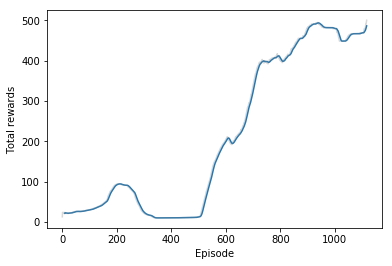

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

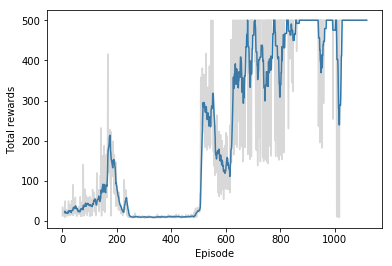

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

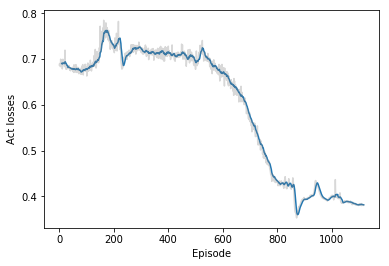

In [18]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

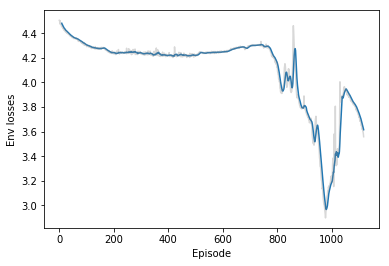

In [19]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

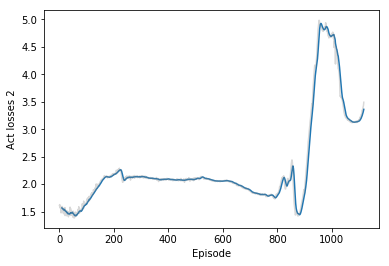

In [20]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
